## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [32]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

Cloning into 'unilm'...
remote: Enumerating objects: 4248, done.
remote: Total 4248 (delta 0), reused 0 (delta 0), pack-reused 4248
Receiving objects: 100% (4248/4248), 7.29 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (2087/2087), done.
Processing ./unilm/layoutlm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached transformers-2.9.0-py3-none-any.whl (635 kB)
  Using cached tokenizers-0.7.0-cp37-cp37m-manylinux1_x86_64.whl (5.6 MB)
  Created wheel for layoutlm: filename=layoutlm-0.0-py3-none-any.whl size=11487 sha256=d6f9fae213f47635c10d132d47d32c83ab11b4bbf2f80079f74a4b0f363906d6
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [33]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 95758, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 95758 (delta 126), reused 141 (delta 72), pack-reused 95500
Receiving objects: 100% (95758/95758), 88.89 MiB | 25.79 MiB/s, done.
Resolving deltas: 100% (70354/70354), done.
Processing ./transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [34]:
# /zipball/master/
# !wget https://github.com/jyotiyadav94/jyotiyadav94.github.io.git/zipball/master/

In [35]:
# !unzip /content/dataset

# #&& mv dataset data166677 && rm -rf dataset.zip __MACOSX

In [36]:
# ! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
# ! unzip dataset.zip && mv dataset data166677 && rm -rf dataset.zip __MACOSX

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

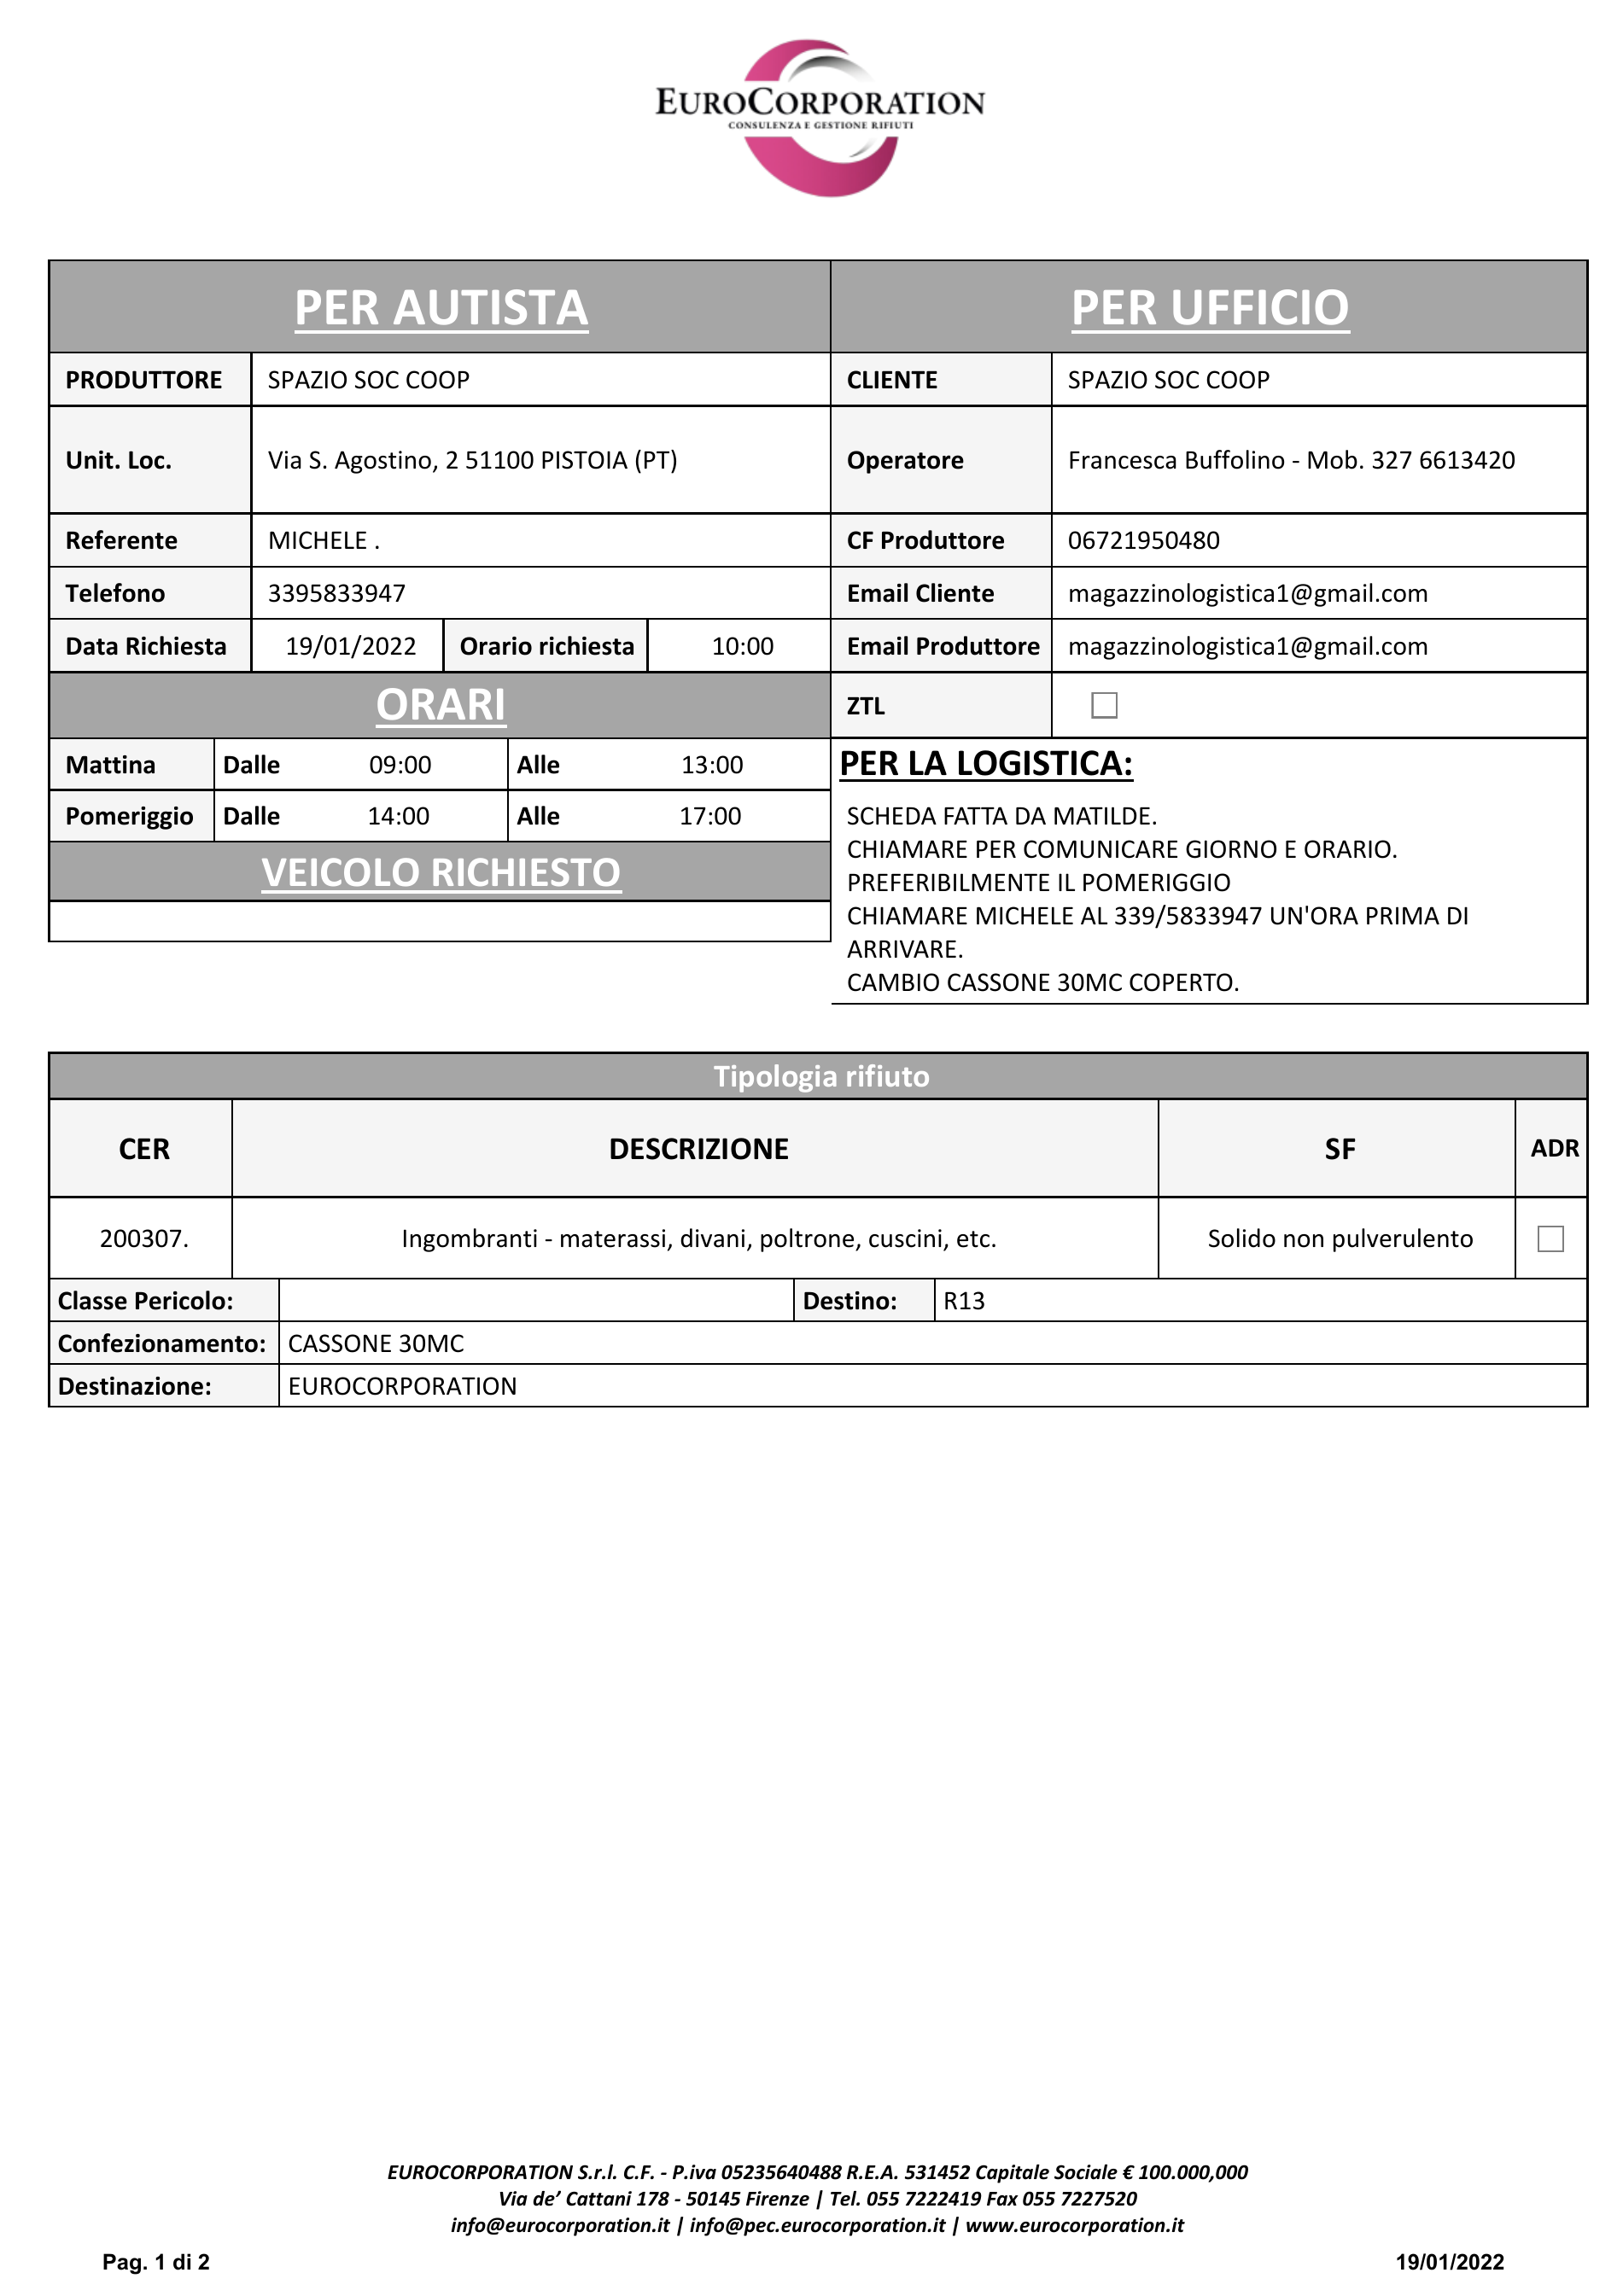

In [38]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/data/training_data/images/1.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [39]:
import json

with open('/content/data/training_data/annotations/1.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [79, 434, 258, 454], 'text': 'PRODUTTORE', 'label': 'PRODUTTORE', 'words': [{'box': [79, 434, 258, 454], 'text': 'PRODUTTORE'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 0}
{'box': [315, 434, 548, 454], 'text': 'SPAZIO SOC COOP', 'label': 'PRODUTTORE_ID', 'words': [{'box': [315, 434, 405, 454], 'text': 'SPAZIO'}, {'box': [416, 434, 466, 454], 'text': 'SOC'}, {'box': [476, 434, 548, 454], 'text': 'COOP'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 1}
{'box': [79, 527, 199, 550], 'text': 'Unit. Loc.', 'label': 'UNIT.LOC', 'words': [{'box': [79, 527, 140, 549], 'text': 'Unit.'}, {'box': [151, 528, 199, 550], 'text': 'Loc.'}], 'linking': [[2, 3, 'PER_AUTISTA']], 'id': 2}
{'box': [314, 523, 791, 556], 'text': 'Via S. Agostino, 2 51100 PISTOIA (PT)', 'label': 'UNIT.LOC_ID', 'words': [{'box': [314, 528, 351, 548], 'text': 'Via'}, {'box': [360, 523, 397, 556], 'text': 'S.'}, {'box': [392, 528, 511, 554], 'text': 'Agostino,'}, {'box': [523, 528, 535, 548], 'text': '2'}, {'box': [546, 5

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

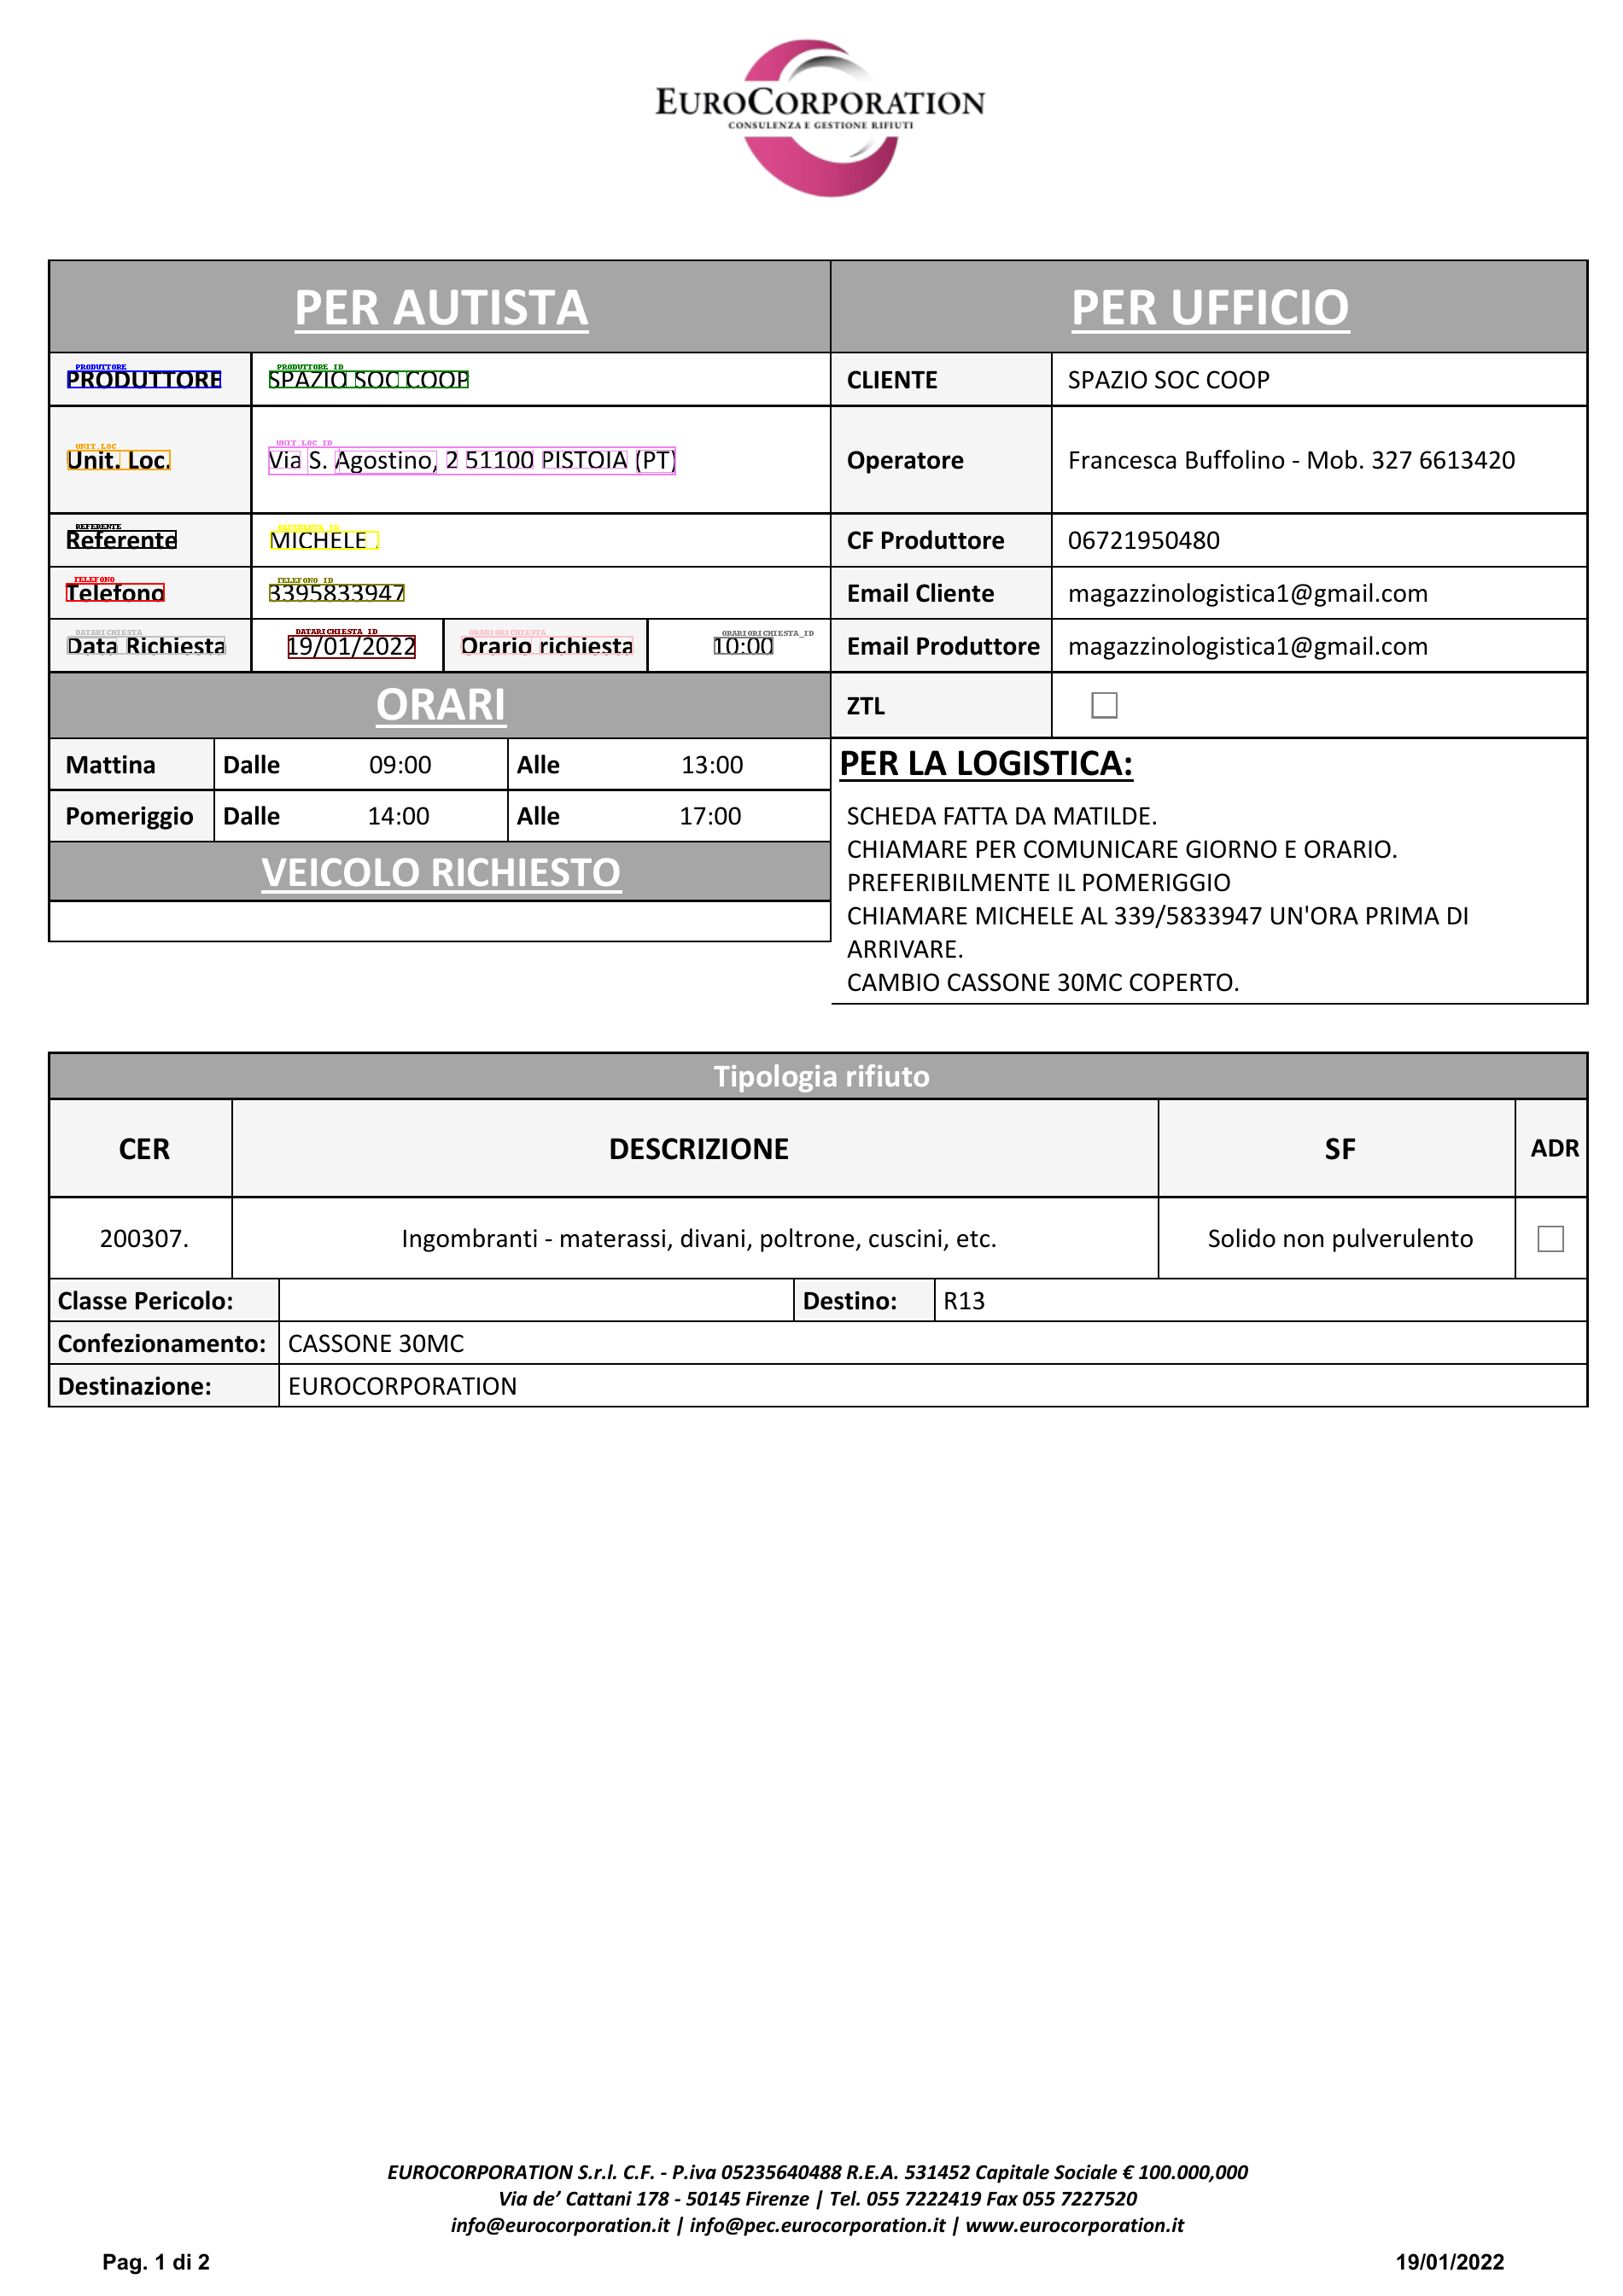

In [40]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'PRODUTTORE':'blue', 'PRODUTTORE_ID':'green', 'UNIT.LOC':'orange', 'UNIT.LOC_ID':'violet','REFERENTE':'black','REFERENTE_ID':'yellow','TELEFONO':'red','TELEFONO_ID':'olive','DATARICHIESTA':'silver','DATARICHIESTA_ID':'maroon','ORARIORICHIESTA':'pink','ORARIORICHIESTA_ID':'grey'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [56]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir /content/data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir /content/data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [57]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [58]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [59]:
print(labels)

['O', 'B-DATARICHIESTA', 'B-ORARIORICHIESTA', 'B-PRODUTTORE_ID', 'B-REFERENTE_ID', 'B-TELEFONO', 'B-UNIT.LOC', 'B-UNIT.LOC_ID', 'E-DATARICHIESTA', 'E-ORARIORICHIESTA', 'E-PRODUTTORE_ID', 'E-REFERENTE_ID', 'E-TELEFONO', 'E-UNIT.LOC', 'E-UNIT.LOC_ID', 'I-PRODUTTORE_ID', 'I-UNIT.LOC_ID', 'S-DATARICHIESTA_ID', 'S-ORARIORICHIESTA_ID', 'S-PRODUTTORE', 'S-REFERENTE', 'S-TELEFONO', 'S-TELEFONO_ID']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [60]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

In [61]:
len(train_dataloader)

2

In [62]:
len(eval_dataloader)

1

In [63]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] produttore spazio soc coop unit. loc. via s. agostino, 2 51100 pistoia ( pt ) referente michele. telefono 3395833947 data richiesta 19 / 01 / 2022 orario richiesta 10 : 00 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [64]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

Now we can start training:

In [65]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Training:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s]

Loss after 0 steps: 3.1748714447021484


Training: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


## Evaluation

Now let's evaluate on the test set:

In [66]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]

{'loss': 1.0487219095230103, 'precision': 0.7692307692307693, 'recall': 0.8333333333333334, 'f1': 0.8}


In [67]:
PATH='/content/data/layoutLM.pt'
torch.save(model.state_dict(), PATH)

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [68]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (6,026 kB/s)
debconf: unable to initi

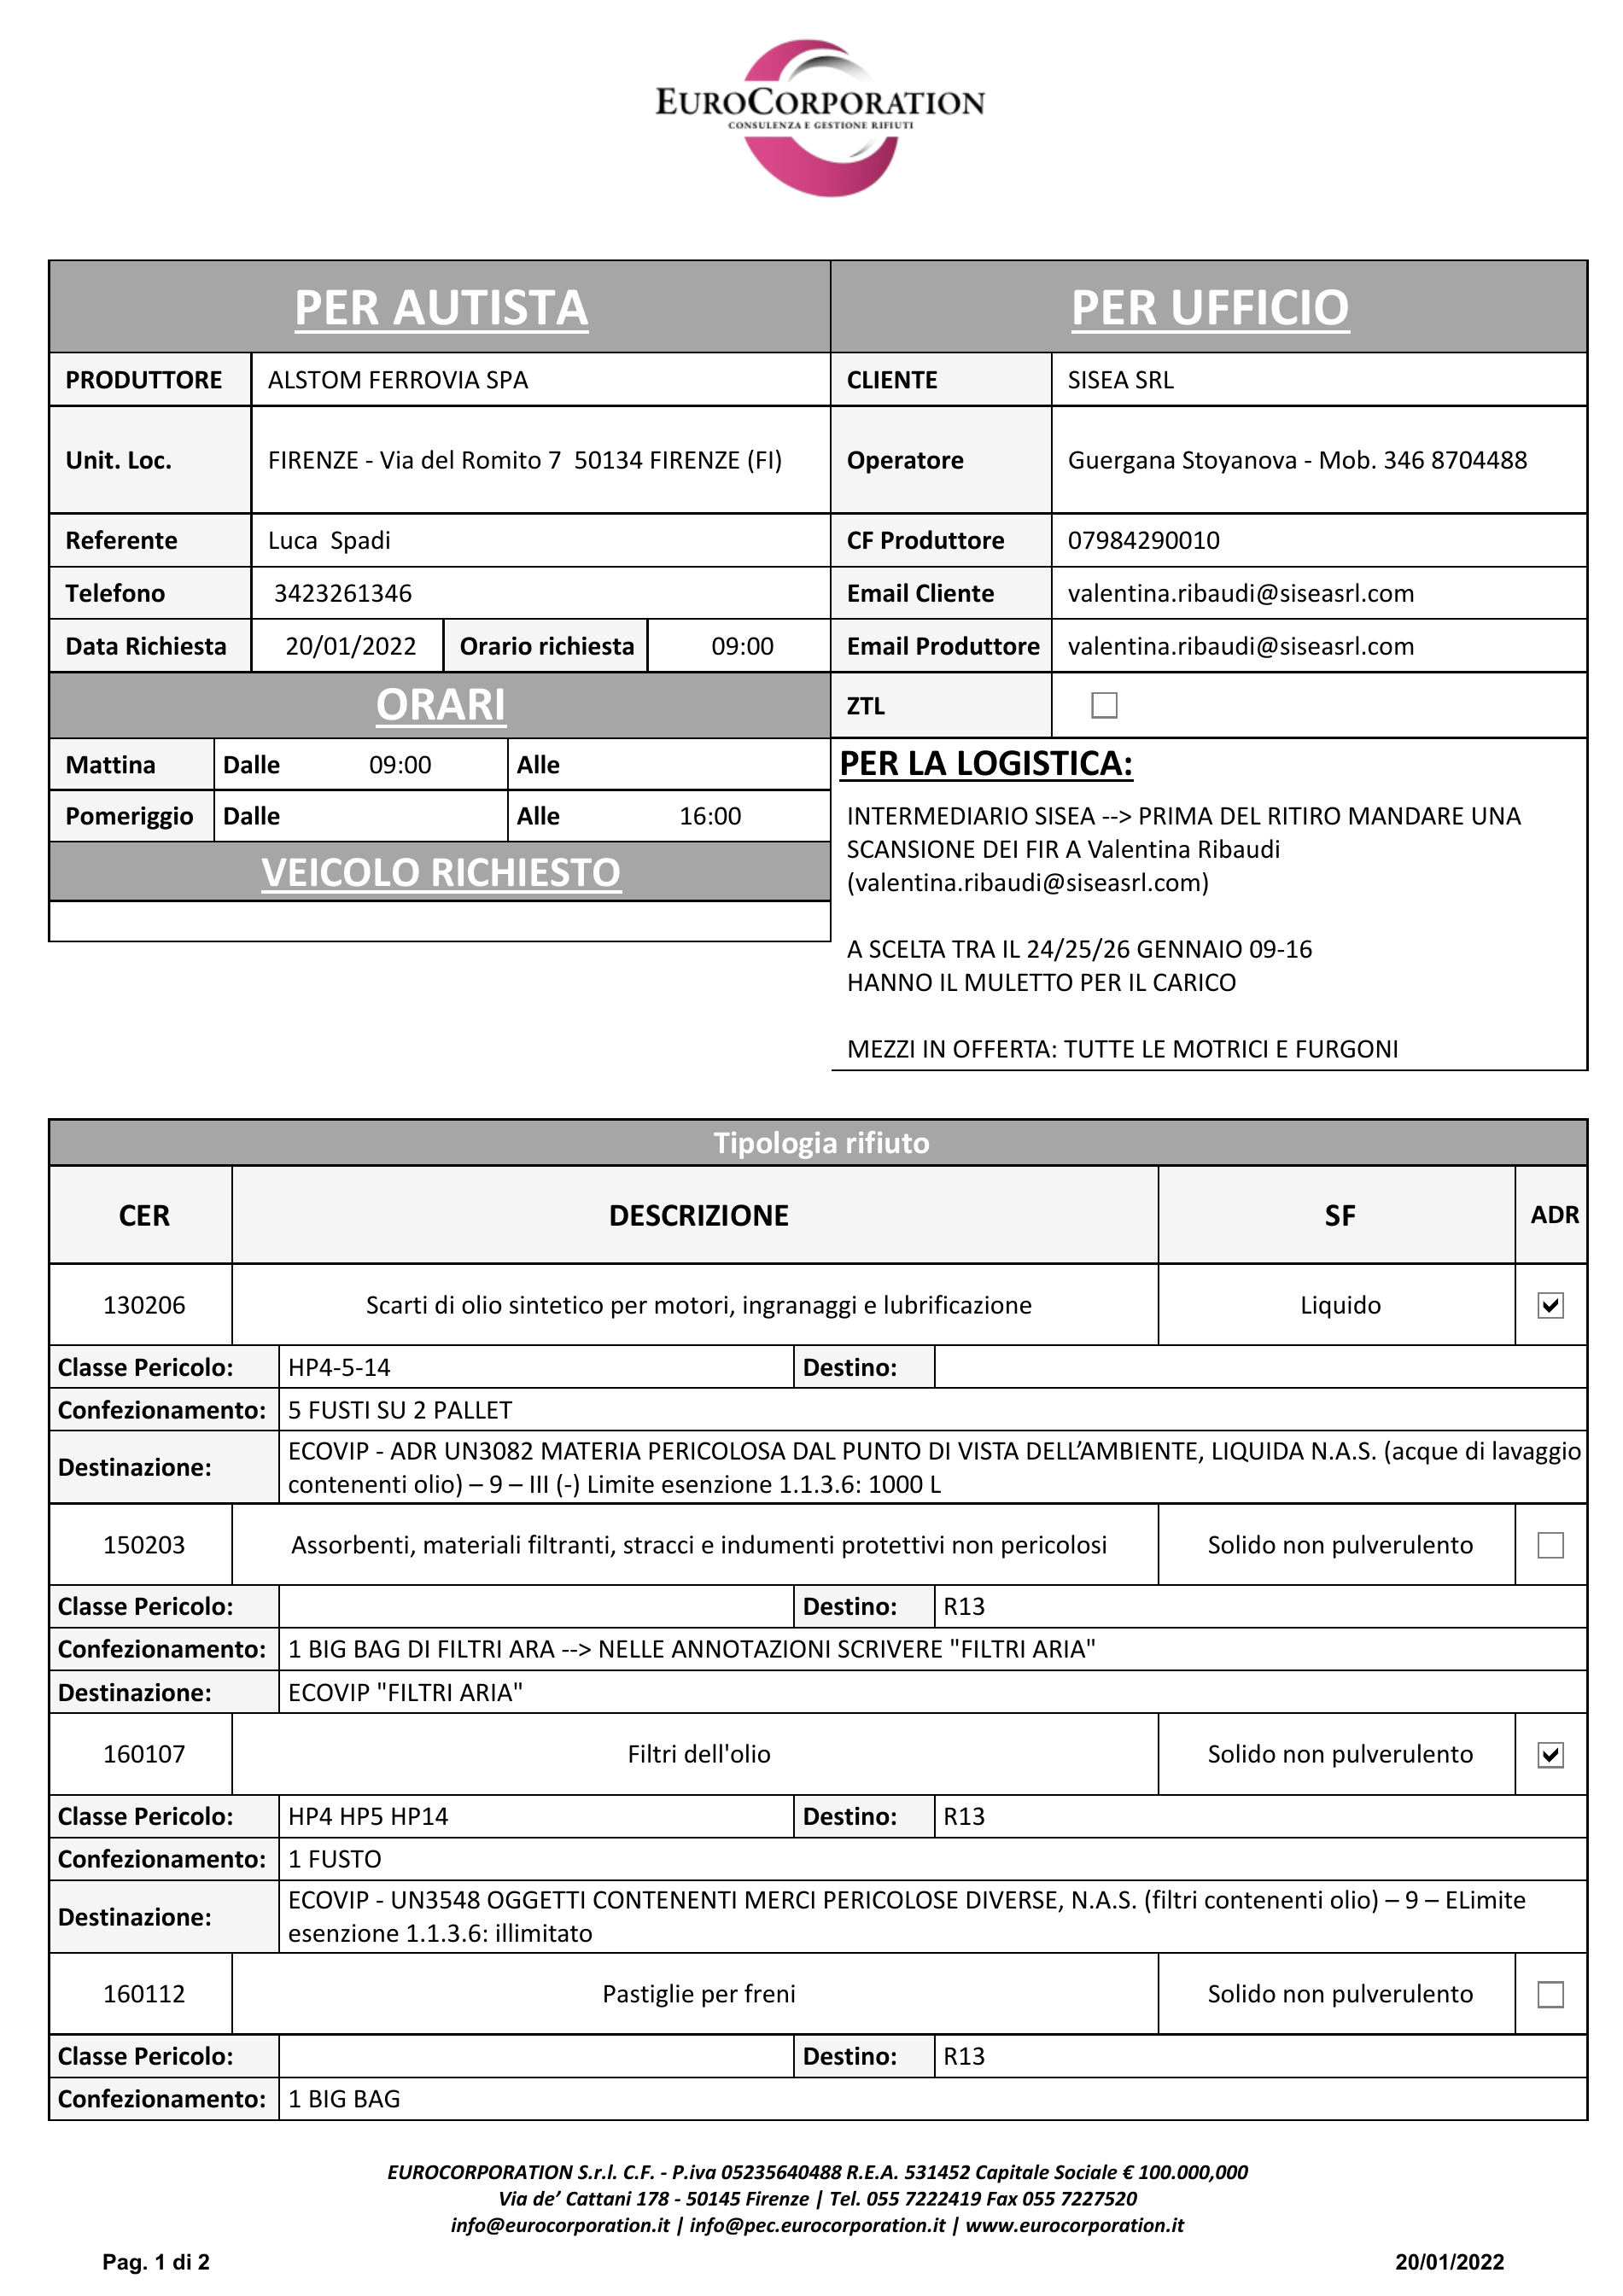

In [70]:
import pytesseract

image = Image.open("/content/data/5.png")
image = image.convert("RGB")
image

In [75]:
import layoutlm_preprocess

import sys
sys.path.insert(1, '/content/data/layoutLM.pt')

from layoutlm_preprocess import *
image_path='/content/data/5.png'
image, words, boxes, actual_boxes = preprocess(image_path)

In [76]:
model_path='/content/data/layoutLM.pt'
model=model_load(model_path,num_labels)
word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

[16, 16, 16, 16, 16, 19, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 14, 13, 13, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 20, 16, 16, 19, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 21, 16, 16, 22, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 1, 8, 16, 17, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

In [77]:
final_boxes

[[873, 47, 990, 95],
 [769, 103, 1153, 134],
 [79, 434, 259, 455],
 [314, 435, 422, 455],
 [434, 435, 562, 455],
 [571, 435, 619, 455],
 [993, 434, 1097, 455],
 [1252, 435, 1322, 455],
 [1331, 435, 1375, 455],
 [79, 528, 140, 549],
 [79, 528, 140, 549],
 [151, 529, 200, 549],
 [151, 529, 200, 549],
 [316, 529, 404, 549],
 [408, 529, 436, 549],
 [445, 528, 483, 549],
 [494, 527, 530, 549],
 [543, 528, 633, 549],
 [643, 529, 656, 549],
 [674, 529, 752, 549],
 [763, 529, 851, 549],
 [854, 527, 915, 554],
 [854, 527, 915, 554],
 [854, 527, 915, 554],
 [993, 528, 1128, 555],
 [1252, 529, 1375, 555],
 [1386, 529, 1518, 555],
 [1528, 540, 1536, 542],
 [1547, 527, 1604, 549],
 [1547, 527, 1604, 549],
 [1608, 529, 1668, 549],
 [1678, 529, 1788, 549],
 [79, 621, 207, 643],
 [993, 622, 1023, 643],
 [1033, 621, 1176, 643],
 [1252, 623, 1428, 643],
 [316, 623, 370, 643],
 [388, 621, 456, 649],
 [77, 683, 193, 705],
 [323, 685, 482, 705],
 [994, 683, 1063, 705],
 [1073, 683, 1164, 705],
 [1252, 683,

In [ ]:
# final_boxes=final_boxes[:4]
# print('final_boxes',final_boxes)

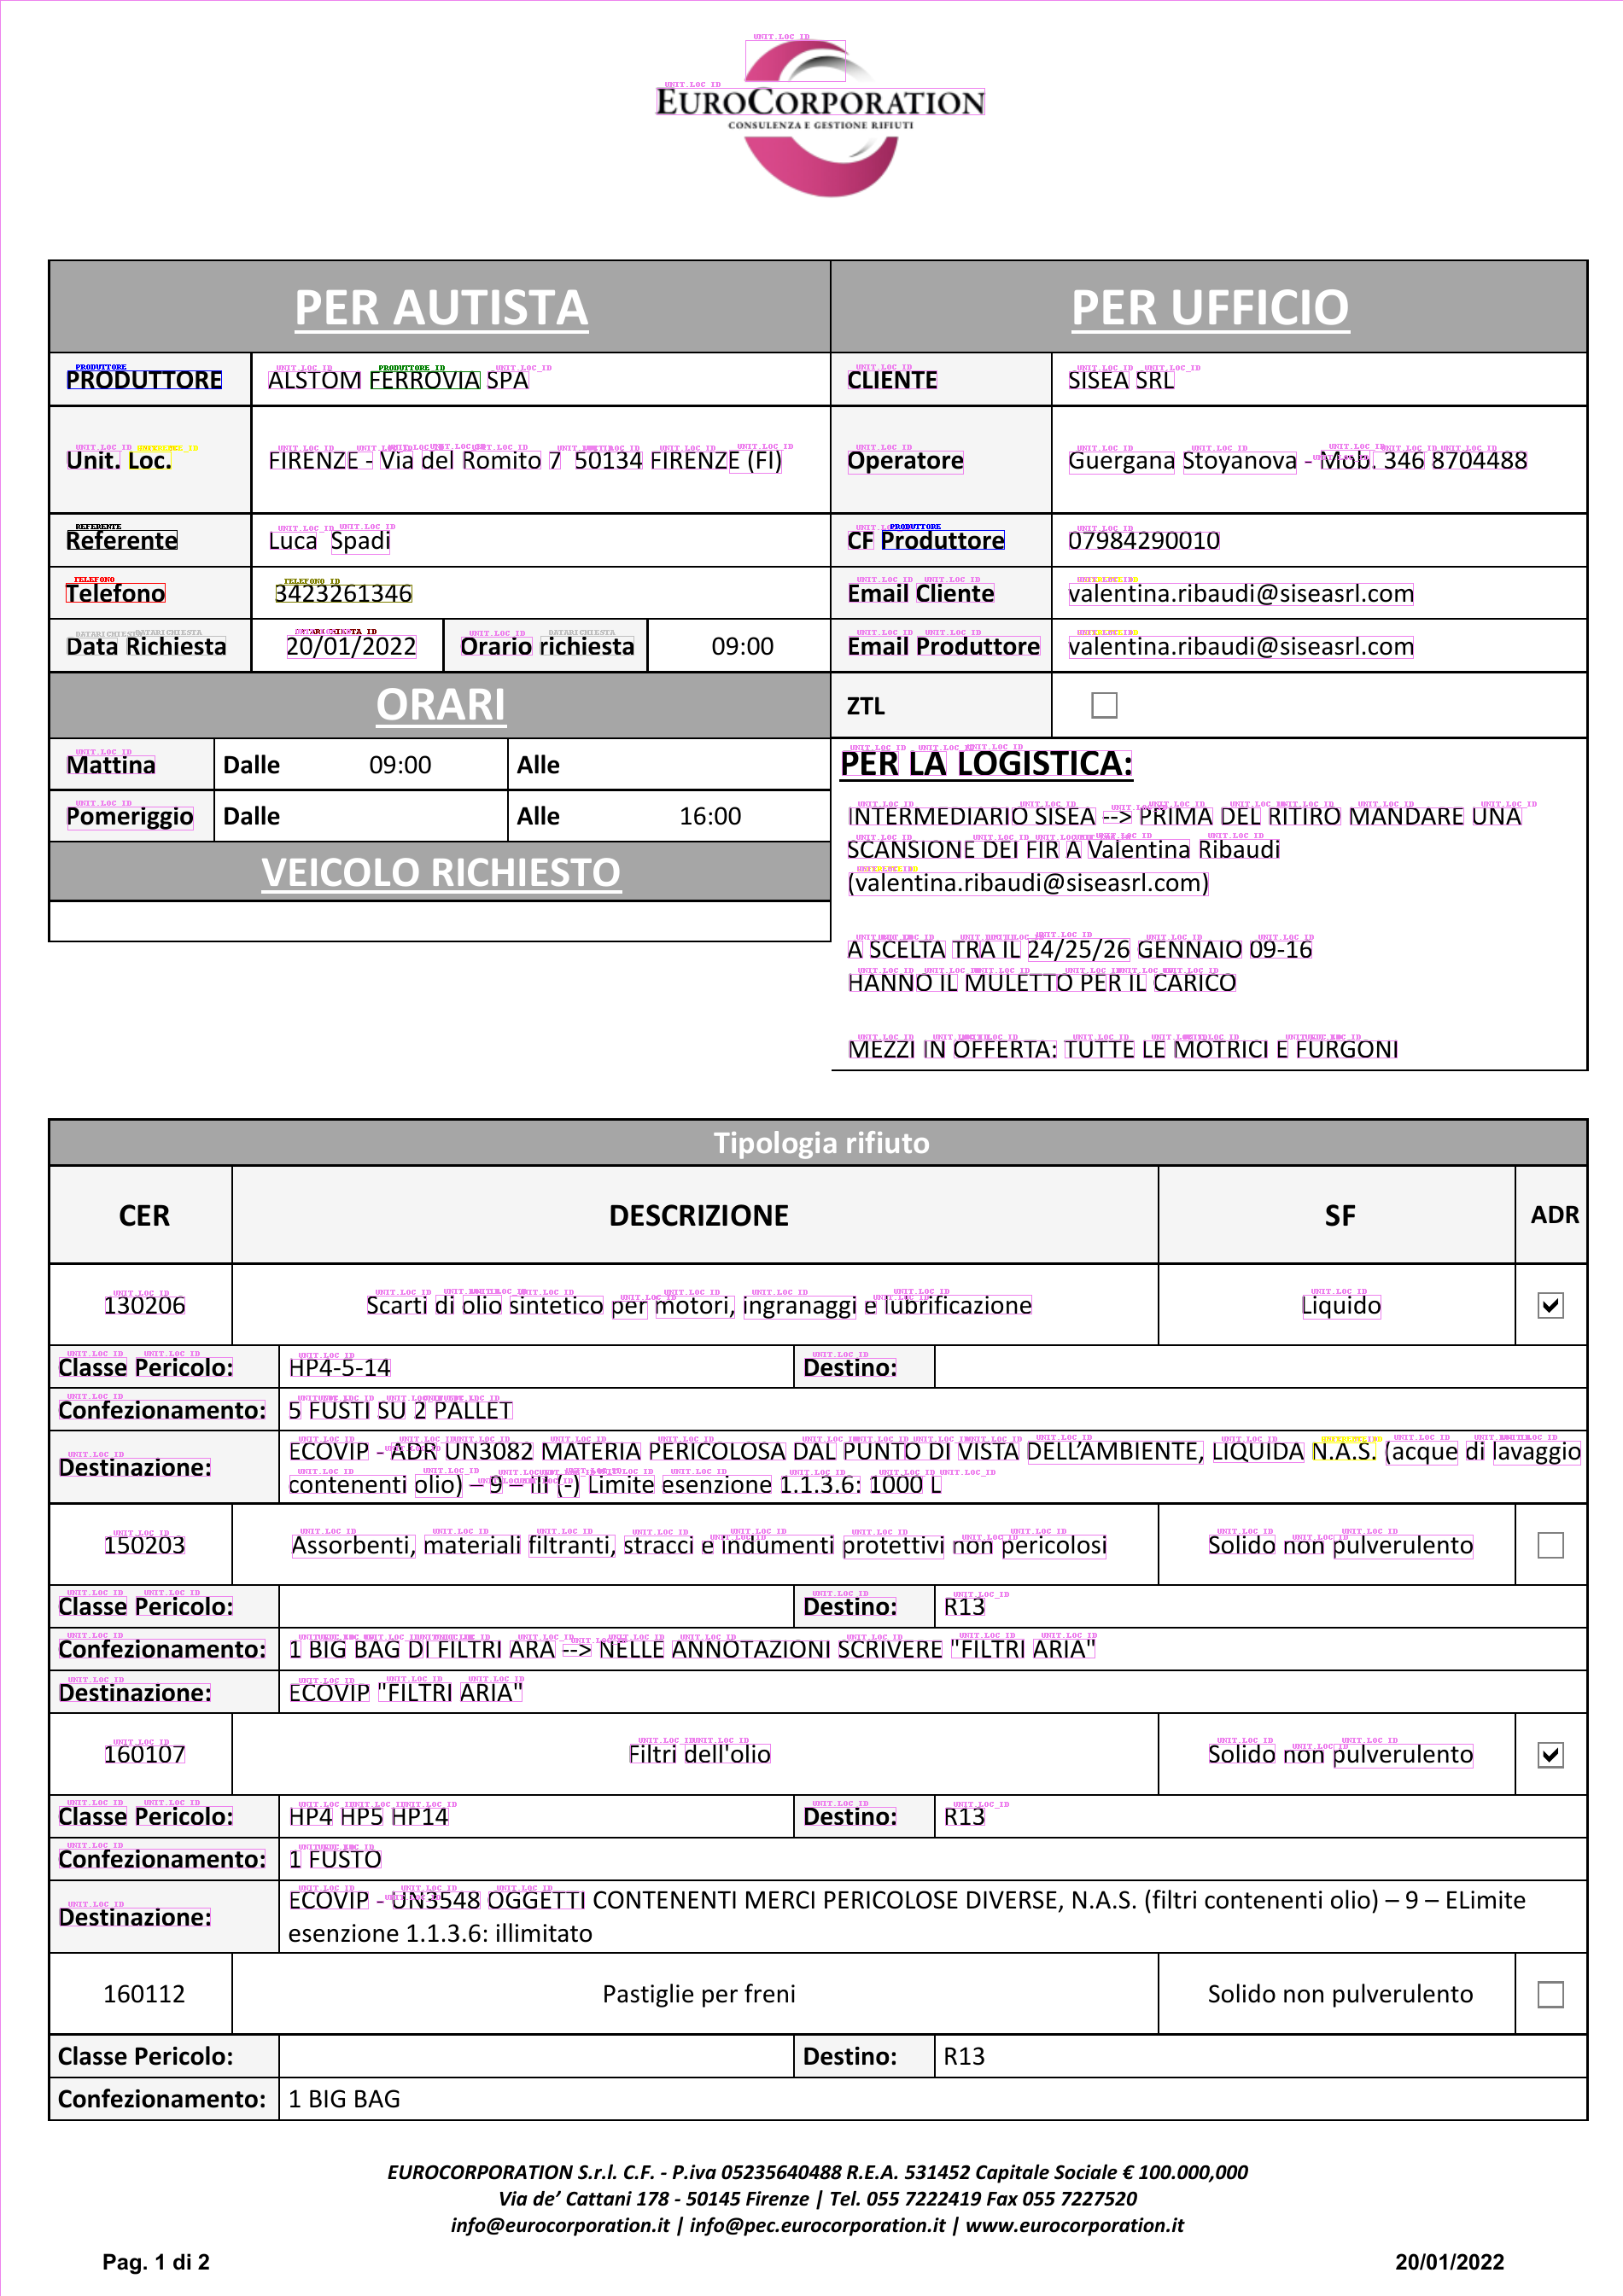

In [79]:


draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""
label2color = {'PRODUTTORE':'blue', 'PRODUTTORE_ID':'green', 'UNIT.LOC':'orange', 'UNIT.LOC_ID':'violet','REFERENTE':'black','REFERENTE_ID':'yellow','TELEFONO':'red','TELEFONO_ID':'olive','DATARICHIESTA':'silver','DATARICHIESTA_ID':'maroon','ORARIORICHIESTA':'pink','ORARIORICHIESTA_ID':'grey'}
for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction])
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

In [82]:
import json

with open('/content/data/5.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [79, 434, 259, 456], 'text': 'PRODUTTORE', 'label': 'PRODUTTORE', 'words': [{'box': [79, 434, 259, 456], 'text': 'PRODUTTORE'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 0}
{'box': [314, 434, 618, 454], 'text': 'ALSTOM FERROVIA SPA', 'label': 'PRODUTTORE_ID', 'words': [{'box': [314, 434, 421, 454], 'text': 'ALSTOM'}, {'box': [434, 434, 561, 454], 'text': 'FERROVIA'}, {'box': [571, 434, 618, 454], 'text': 'SPA'}], 'linking': [[0, 1, 'PER_AUTISTA']], 'id': 1}
{'box': [79, 527, 199, 550], 'text': 'Unit. Loc.', 'label': 'UNIT.LOC', 'words': [{'box': [79, 527, 140, 549], 'text': 'Unit.'}, {'box': [151, 528, 199, 550], 'text': 'Loc.'}], 'linking': [[2, 3, 'PER_AUTISTA']], 'id': 2}
{'box': [316, 527, 914, 553], 'text': 'FIRENZE - Via del Romito 7 50134 FIRENZE (FI)', 'label': 'UNIT.LOC_ID', 'words': [{'box': [316, 529, 418, 548], 'text': 'FIRENZE'}, {'box': [429, 540, 435, 541], 'text': '-'}, {'box': [445, 528, 482, 548], 'text': 'Via'}, {'box': [494, 527, 530, 548], 'text': 'del'}, 

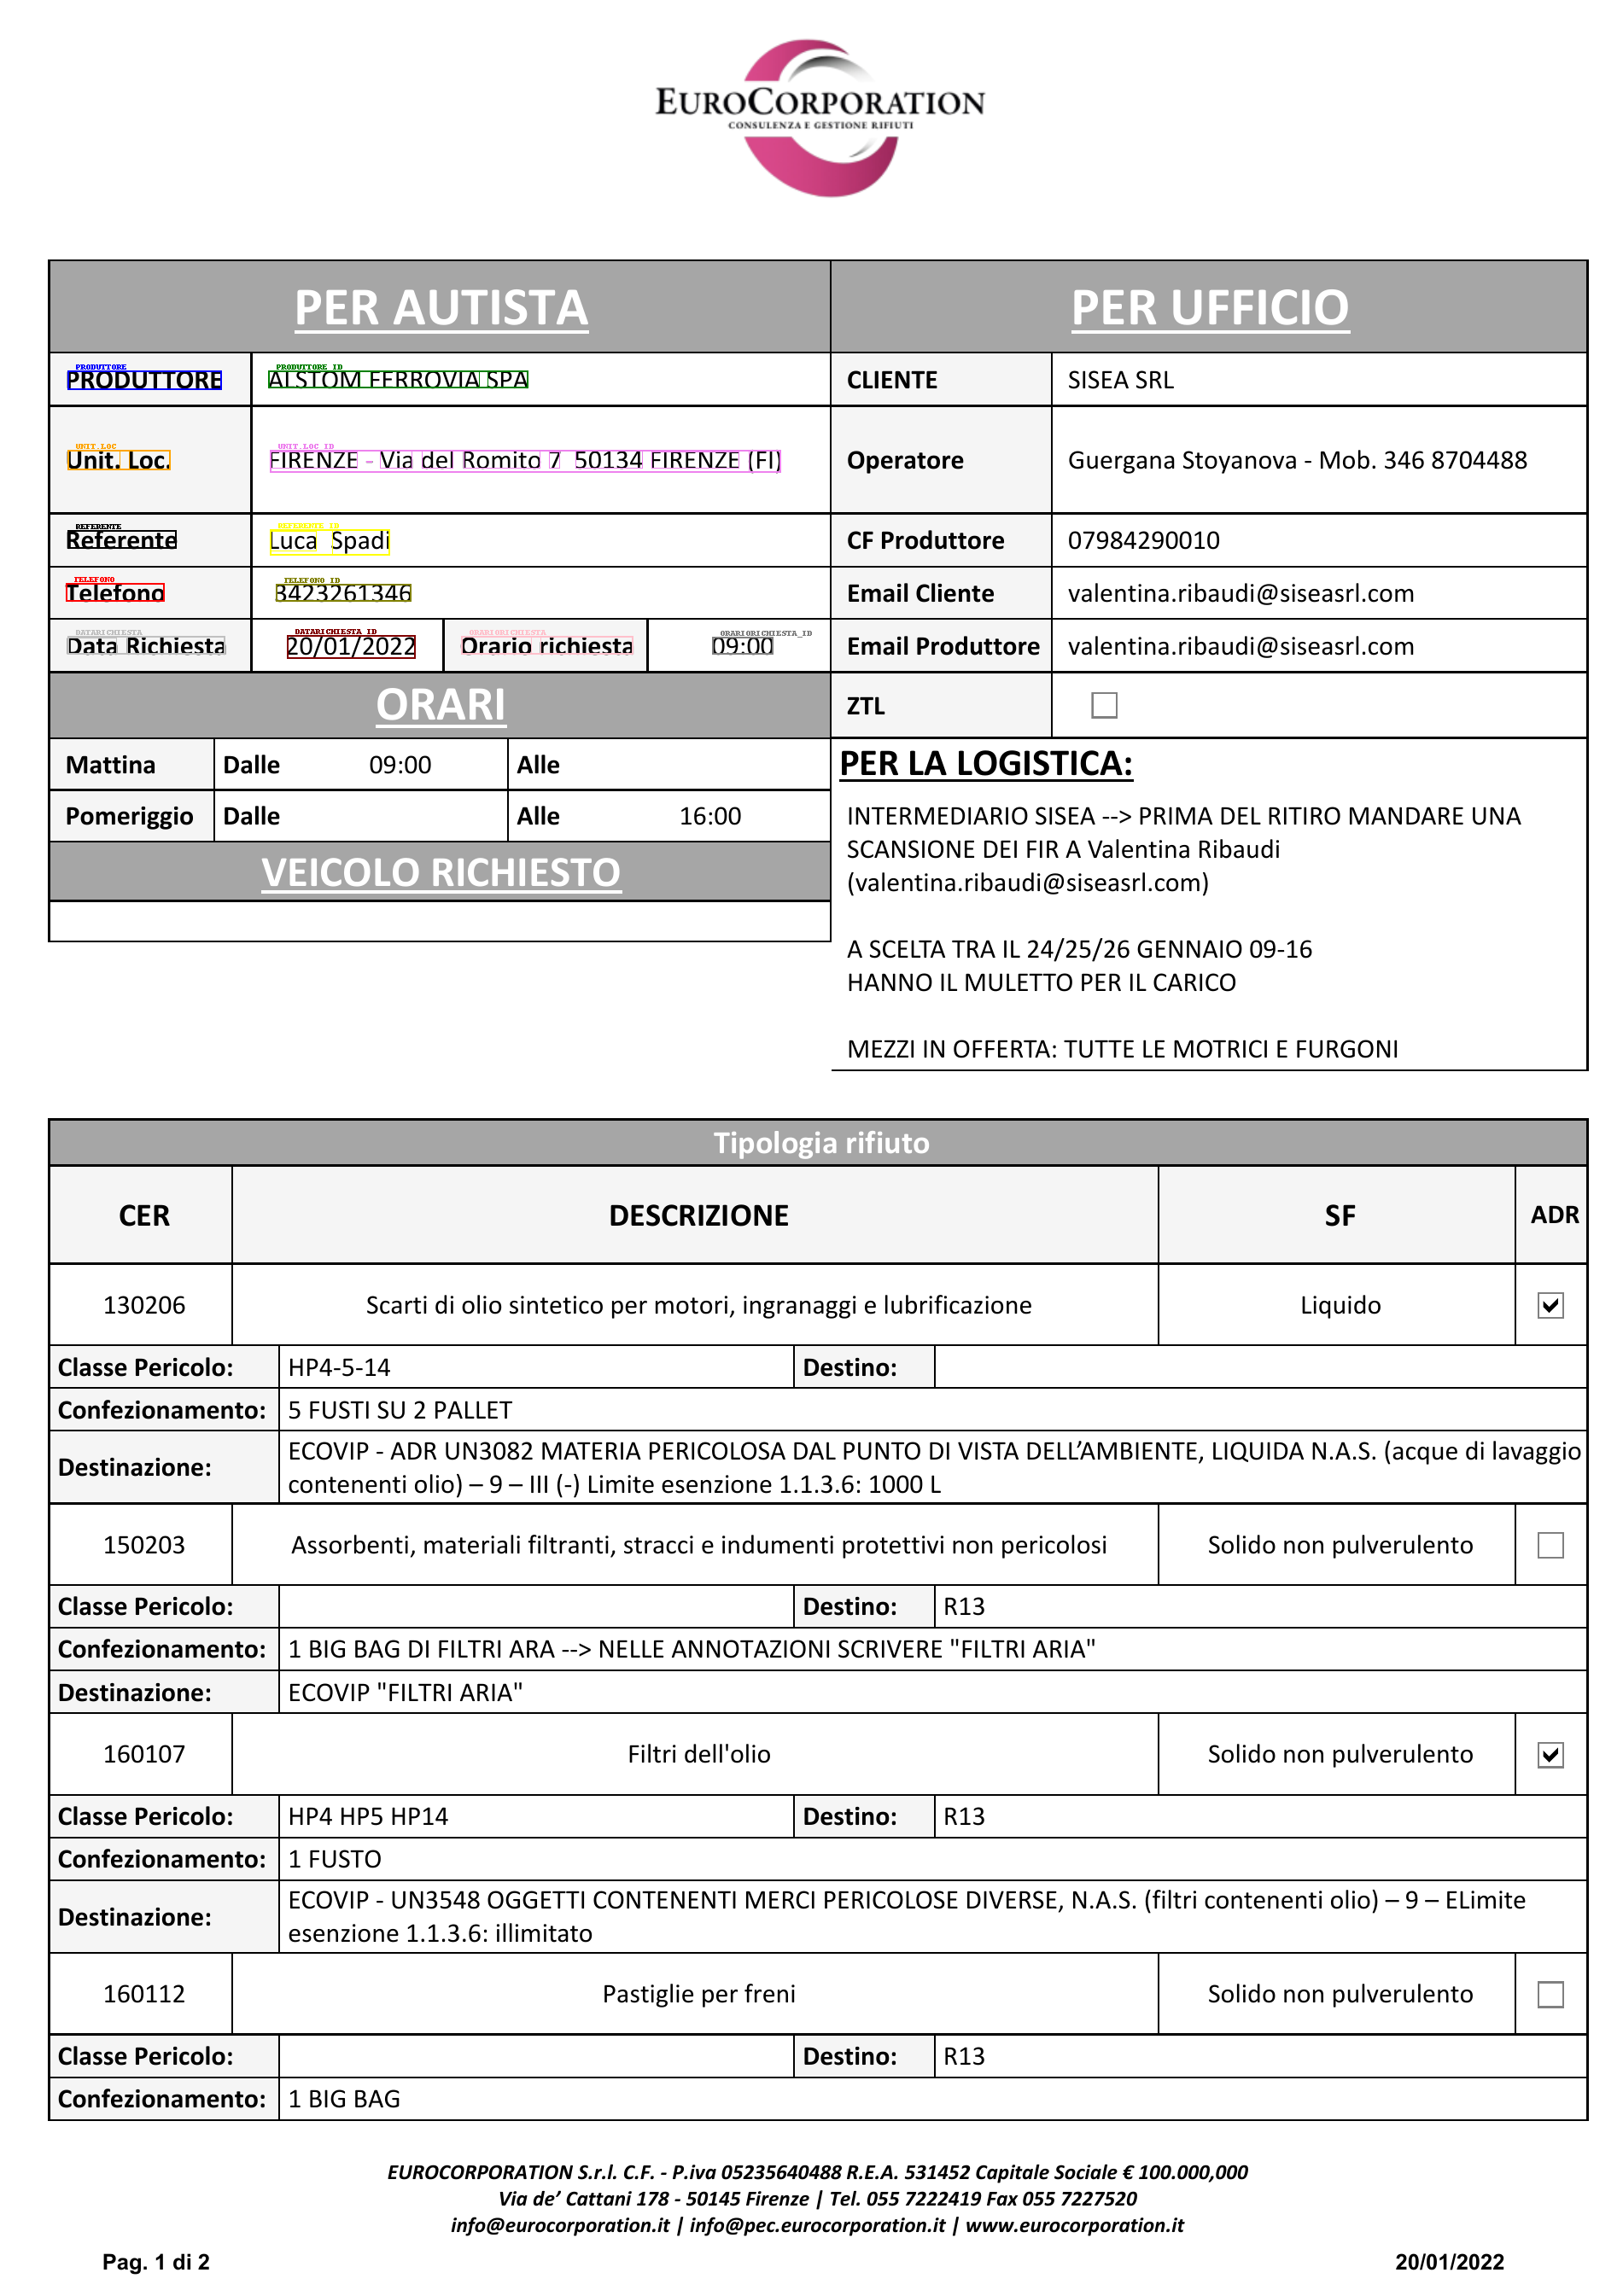

In [85]:
image = Image.open("/content/data/5.png")
image = image.convert('RGB')

draw = ImageDraw.Draw(image)

label2color = {'PRODUTTORE':'blue', 'PRODUTTORE_ID':'green', 'UNIT.LOC':'orange', 'UNIT.LOC_ID':'violet','REFERENTE':'black','REFERENTE_ID':'yellow','TELEFONO':'red','TELEFONO_ID':'olive','DATARICHIESTA':'silver','DATARICHIESTA_ID':'maroon','ORARIORICHIESTA':'pink','ORARIORICHIESTA_ID':'grey'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image